In [2]:
#importing libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt # visualizing data
%matplotlib inline
import seaborn as sns

In [3]:
# import csv file
data = pd.read_csv('housing.csv', encoding= 'unicode_escape')

In [ ]:
data.head(30)

In [ ]:
data.shape

In [ ]:
data.columns


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  int64  
 1   longitude           20640 non-null  float64
 2   latitude            20640 non-null  float64
 3   housing_median_age  20640 non-null  int64  
 4   total_rooms         20640 non-null  int64  
 5   total_bedrooms      20433 non-null  float64
 6   population          20640 non-null  int64  
 7   households          20640 non-null  int64  
 8   median_income       20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [ ]:
data.describe()

In [ ]:
#columns visualization

In [ ]:
data.hist(figsize=(8,8),layout=(3,5))
plt.show()

In [ ]:
data.plot(kind='box',figsize=(8,8),subplots=True,layout=(3,5))
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True)
plt.show()

In [ ]:
                                    #data pre-processing

In [4]:
data.isnull().sum()

# fix the null values by using KNN imputer
numerical_cols = ['total_bedrooms']
def FixUsingImputer(data, numerical_cols):
    Imputer = KNNImputer(n_neighbors = 5)
    Imputer.fit(data.loc[: , numerical_cols])
    Imputed_data = Imputer.transform(data.loc[ : , numerical_cols])
    data.loc[ : , numerical_cols] =   Imputed_data
    return data
data = FixUsingImputer(data , numerical_cols )

data.isnull().sum()
    

median_house_value    0
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

In [5]:
#categorical column = ocean_poximity
data['ocean_proximity'].value_counts()

#apply onehotencoder on ocean_poximity
Cols = ['ocean_proximity']
def ApplyOneHotEncoding(data , Cols):
    ohe = OneHotEncoder(sparse = False)
    ohe.fit(data[[Cols]])
    oheMatrix = ohe.transform(data[[Cols]])
    Encodings = pd.DataFrame(oheMatrix[:,:-1], columns = [Cols+col for col in ohe.categories_[0][:-1]])
    data.drop([Cols] , axis = 1 , inplace = True)
    data = pd.concat([data , Encodings],axis=1)
    return data
for col in Cols:
    data = ApplyOneHotEncoding(data , col)

In [ ]:
data.head()

In [6]:
                            #fixing ouliers with KNN
    
Numerical_cols = list(data.columns[4:-4])
print(Numerical_cols)
def FixOutliers(data ,col_name , idxs):
    data.loc[idxs , col_name] = np.nan
    Imputer = KNNImputer()
    Imputer.fit(data.loc[: , Numerical_cols])
    data.loc[: , Numerical_cols] = Imputer.transform(data.loc[: , Numerical_cols])
    return data

['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [7]:
                        #detecting outliers with Zscore

def DetectOutliers_Zscore(data ,col_name):
    mean = data[col_name].mean()
    std = data[col_name].std()
    high_threshold = mean + 10* std
    low_threshold = mean - 10* std
    high_boolean_vector = data[col_name].values>high_threshold
    low_boolean_vector = data[col_name].values<low_threshold
    
    outlier_boolean_vector  = np.logical_or(high_boolean_vector  ,  low_boolean_vector)
    idxs = np.where(outlier_boolean_vector)[0]
    
    print("No. of Outliers detected in " ,col_name ,' :' , len(idxs))
    plt.plot(data[col_name].values)
    plt.plot([high_threshold] * data.shape[0])
    plt.plot([low_threshold] * data.shape[0])
    plt.show()
    
    if len(idxs):
        data = FixOutliers(data , col_name , idxs) 
        print("After Fixing Outliers: ")
        plt.plot(data[col_name].values)
        plt.plot([high_threshold] * data.shape[0])
        plt.plot([low_threshold] * data.shape[0])
        plt.show()
    
    return data

No. of Outliers detected in  total_rooms  : 14


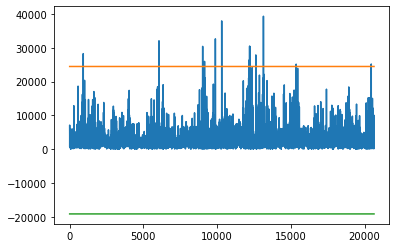

After Fixing Outliers: 


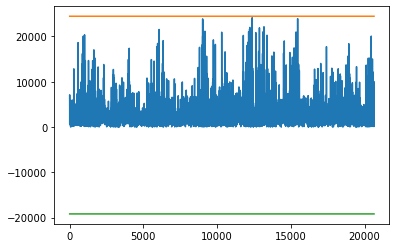

No. of Outliers detected in  total_bedrooms  : 11


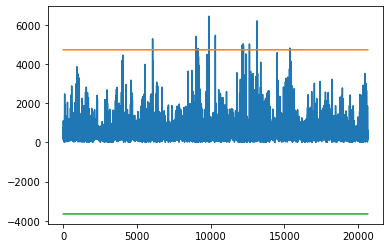

After Fixing Outliers: 


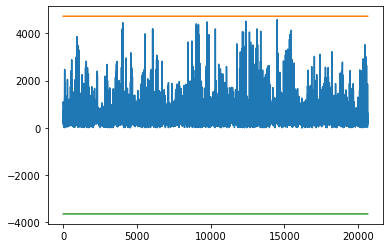

No. of Outliers detected in  population  : 8


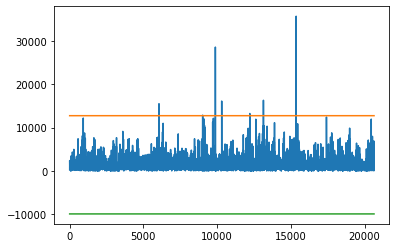

After Fixing Outliers: 


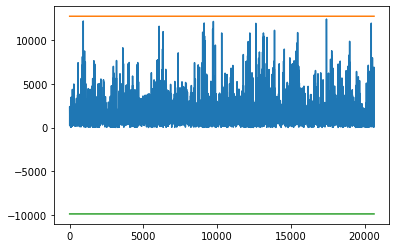

No. of Outliers detected in  households  : 11


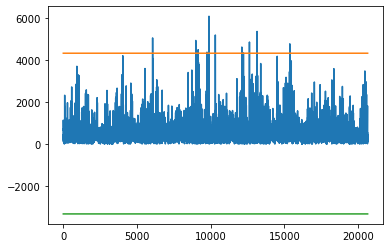

After Fixing Outliers: 


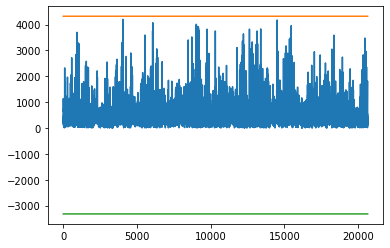

No. of Outliers detected in  median_income  : 0


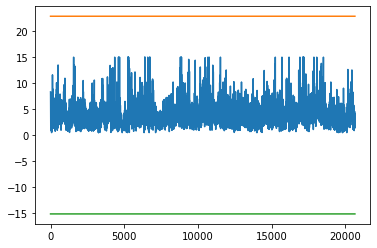

In [8]:
for col in Numerical_cols:
    data = DetectOutliers_Zscore(data , col)

In [8]:
                            #Feature scaling
scaler = StandardScaler()
data.iloc[:,:] = scaler.fit_transform(data)
data.head()

,median_house_value,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity<1H OCEAN,ocean_proximityINLAND,ocean_proximityISLAND,ocean_proximityNEAR BAY
0,2.129631,-1.327835,1.052548,0.982143,-0.804819,-0.975228,-0.974429,-0.977033,2.344766,-0.891156,-0.681889,-0.015566,2.830742
1,1.314156,-1.322844,1.043185,-0.607019,2.045890,1.355088,0.861439,1.669961,2.332238,-0.891156,-0.681889,-0.015566,2.830742
2,1.258693,-1.332827,1.038503,1.856182,-0.535746,-0.829732,-0.820777,-0.843637,1.782699,-0.891156,-0.681889,-0.015566,2.830742
3,1.165100,-1.337818,1.038503,1.856182,-0.624215,-0.722399,-0.766028,-0.733781,0.932968,-0.891156,-0.681889,-0.015566,2.830742
4,1.172900,-1.337818,1.038503,1.856182,-0.462404,-0.615066,-0.759847,-0.629157,-0.012881,-0.891156,-0.681889,-0.015566,2.830742


In [ ]:
data.std()

In [ ]:
data.mean()

In [9]:
                        #train , test , split
x , y= data.iloc[: , 1:] , data.iloc[: , 0]
x_train, x_test, y_train, y_test = train_test_split( x , y, random_state=0, test_size=0.2 , shuffle = True)

print("Training Shape : " , x_train.shape,  y_train.shape)
print("Training Shape : " , x_test.shape,  y_test.shape)

Training Shape :  (16512, 12) (16512,)
Training Shape :  (4128, 12) (4128,)


In [9]:
                                #define the metrices
                                #1.MeanSquaredError
                                #2.RootMeanSquaredError
                                #3.R2Score
                                #4.MeanAbsoluteError

In [10]:
def PrintTheMetrics(actual , predicted):
    print("MeanSquaredError: " , MeanSquaredError(y_test , predictions)) 
    print("RootMeanSquaredError: " , RootMeanSquaredError(y_test , predictions))
    print("R2Score: " , R2Score(y_test , predictions))
    print("MeanAbsoluteError: " , MeanAbsoluteError(y_test , predictions))

In [11]:
def MeanSquaredError(actual , predicted):
    Error = actual - predicted
    squaredError = np.square(actual - predicted)
    MSE = np.mean(squaredError)
    return MSE

In [12]:
def RootMeanSquaredError(actual , predicted):
    RMSE = np.sqrt(MeanSquaredError(actual , predicted))
    return RMSE

In [13]:
def  R2Score(actual, predicted):
    SSR = np.sum(np.square(actual - predicted))
    SSM = np.sum(np.square(actual - np.mean(actual)))
    return 1 - (SSR / SSM)

In [14]:
def MeanAbsoluteError(actual , predicted):
    return np.mean(np.abs(actual - predicted))

In [17]:
#define the model : LinearRegression
lr = LinearRegression()
lr.fit(x_train , y_train)
predictions = lr.predict(x_test)

#evaluation metrics
PrintTheMetrics(y_test , predictions)

#Accuracy Traing Test
print("Training Set Accuracy: " , lr.score(x_train , y_train))
#Accuracy Traing Test
print("Testing Set Accuracy: " , lr.score(x_test, y_test))

MeanSquaredError:  0.3538768681114334
RootMeanSquaredError:  0.5948755063972909
R2Score:  0.6386340899602367
MeanAbsoluteError:  0.43056061692402847
Training Set Accuracy:  0.6515382048268801
Testing Set Accuracy:  0.6386340899602367


In [18]:
#define the model: RandomForestRegressor
RF = RandomForestRegressor()
RF.fit(x_train , y_train)
predictions = RF.predict(x_test)

#evaluation metrics
PrintTheMetrics(y_test , predictions)

#Accuracy Traing Test
print("Training Set Accuracy: " , RF.score(x_train , y_train))
#Accuracy Traing Test
print("Testing Set Accuracy: " , RF.score(x_test, y_test))

MeanSquaredError:  0.1708466490123299
RootMeanSquaredError:  0.41333600014072075
R2Score:  0.8255377495368145
MeanAbsoluteError:  0.2708275659134304
Training Set Accuracy:  0.9752820742606986
Testing Set Accuracy:  0.8255377495368145


In [15]:
#Define the Model : GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(x_train , y_train)
predictions = gb.predict(x_test)
PrintTheMetrics(y_test , predictions)

#Accuracy Traing Test
print("Training Set Accuracy: " , gb.score(x_train , y_train))
#Accuracy Traing Test
print("Testing Set Accuracy: " , gb.score(x_test, y_test))

MeanSquaredError:  0.22973492708141235
RootMeanSquaredError:  0.4793067150389324
R2Score:  0.7654032278635652
MeanAbsoluteError:  0.33293104839940507
Training Set Accuracy:  0.7849035214750297
Testing Set Accuracy:  0.7654032278635652


In [ ]:
                          #define the model: RandomForestRegressor

In [ ]:
                                   #grid search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search = GridSearchCV(rf , param_grid)
grid_search.fit(x_train , y_train)


#Check best Param and best Model
print(grid_search.best_params_)
best_model = grid_search.best_estimator_
print(best_model)

#predictions
predictions = best_model.predict(x_test)
#evaluation metrics
PrintTheMetrics(y_test , predictions)


#Accuracy Traing Test
print("Training Set Accuracy: " , best_model.score(x_train , y_train))
#Accuracy Testing Test
print("Testing Set Accuracy: " , best_model.score(x_test, y_test))

In [ ]:
                                      #random search 

from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}




# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train , y_train)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
#Check best Param and best Model
print(rf_random.best_params_)
best_model = rf_random.best_estimator_
print(best_model)

#predictions
predictions = best_model.predict(x_test)
#evaluation metrics
PrintTheMetrics(y_test , predictions)


#Accuracy Traing Test
print("Training Set Accuracy: " , best_model.score(x_train , y_train))
#Accuracy Testing Test
print("Testing Set Accuracy: " , best_model.score(x_test, y_test))

In [ ]:
                          #Define the Model : GradientBoostingRegressor

In [ ]:
                                   #grid search
gbr = GradientBoostingRegressor()
param_grid = {'n_estimators':[100, 500 , 1000], 
             'min_samples_split':[5 , 7 , 9],
              'learning_rate' :[ 0.01, 0.1, 1.0],
             'max_depth' : [ 4 ,7, 9]}

#Fit the Model
grid_search = GridSearchCV(gbr, param_grid)
grid_search.fit(x_train , y_train)

#Check best Param and best Model
print(grid_search.best_params_)
best_model = grid_search.best_estimator_
print(best_model)

#Predictions
predictions = best_model.predict(x_test)
PrintTheMetrics(y_test , predictions)

#Accuracy Traing Test
print("Training Set Accuracy: " , best_model.score(x_train , y_train))
#Accuracy Traing Test
print("Testing Set Accuracy: " , best_model.score(x_test, y_test))

In [16]:
import pickle 
pickle.dump(gb,open('model.pkl','wb'))

In [ ]:
model = pickle.load(open('model.pkl','rb'))